## Setup and import data

In [1]:
# Dependencies and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
path = '../../Project-1_Resources/clean/clean_data.csv'
df_orig = pd.read_csv(path, low_memory=False, index_col=0)
df_orig.shape

(603029, 23)

## Reduce working data to just COVID-19 records, remove uneeded columns

In [3]:
df = df_orig.loc[df_orig['VAX_TYPE'] == 'COVID19'].copy()
df.reset_index(drop=True, inplace=True)
df.drop(columns=['AGE_YRS','SEX','DATEDIED','HOSPDAYS','RECOVD','NUMDAYS','RECVDATE','ALLERGIES','REPORT_DATE','VAX_MANU'], inplace=True)
df

,VAERS_ID,STATE,DIED,L_THREAT,ER_VISIT,HOSPITAL,X_STAY,DISABLE,FORM_VERS,OFC_VISIT,ER_ED_VISIT,VAX_TYPE,VAX_DOSE_SERIES
0,896636,SC,NaN,NaN,NaN,NaN,NaN,NaN,2,Y,Y,COVID19,UNK
1,902418,NJ,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,COVID19,1
2,902440,AZ,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,COVID19,1
3,902446,WV,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,COVID19,1
4,902464,LA,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,Y,COVID19,UNK
...,...,...,...,...,...,...,...,...,...,...,...,...,...
385926,1442854,FL,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,COVID19,2
385927,1442855,RI,NaN,NaN,NaN,NaN,NaN,NaN,2,Y,NaN,COVID19,1
385928,1442856,CA,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,COVID19,1
385929,1442857,DE,NaN,NaN,NaN,Y,NaN,NaN,2,Y,NaN,COVID19,2


## Merge three reporting fields for patient visit to doctor, clinic, urgent care or ER following vaccination

In [4]:
df['DR_ER'] = np.nan
df.loc[(df['ER_VISIT']=="Y")|(df['OFC_VISIT']=="Y")|(df['ER_ED_VISIT']=="Y"), 'DR_ER'] = 'Y'
df.drop(columns=['ER_VISIT', 'OFC_VISIT', 'ER_ED_VISIT'], inplace=True)

## Merge individual outcome fields into a new category field
Addresses instances where a single patient has multiple entries across outcome fields.  
Category assigned using hierarchy from worst (death) to best (no doctor/ER visit outcomes.

In [5]:
conditions = [
    df['DIED'] == 'Y',
    df['DISABLE'] == 'Y',
    df['L_THREAT'] == 'Y',
    df['HOSPITAL'] == 'Y',
    df['DR_ER'] == 'Y',
    df['VAERS_ID'].notnull()
]
outputs = ['Died','Disabled','Life-threatening illness','Hospitalized','Dr or ER visit','None']
df['OUTCOME'] = np.select(conditions, outputs, default='None')
df['OUTCOME'].value_counts()

None                        255246
Dr or ER visit              100522
Hospitalized                 14751
Disabled                      5296
Life-threatening illness      5260
Died                          4856
Name: OUTCOME, dtype: int64

## Import and merge external state data
* Census Bureau regional and subregional groups
* State population
* Percent population receiving at least one dose of COVID-19 vaccine

In [6]:
state_file = '../../Project-1_Resources/clean/state_lookup.csv'
df_st = pd.read_csv(state_file)
df_st.rename(columns={'DIVISION':'SUBREGION'}, inplace=True)

pop_file = '../../Project-1_Resources/clean/StatePop2021.csv'
df_pop = pd.read_csv(pop_file)
df_pop = df_pop[['State','Pop']]
df_pop.rename(columns={'State':'ST_NAME'}, inplace=True)

vac_file = '../../Project-1_Resources/clean/us-covid-19-share-people-vaccinated.csv'
df_vac = pd.read_csv(vac_file)
df_vac_07july = df_vac.loc[df_vac['Day'] == '2021-07-02'].copy()
df_vac_07july.reset_index(drop=True, inplace=True)
df_vac_07july.rename(columns={'Entity':'ST_NAME', 'people_vaccinated_per_hundred':'PCNT_VAC'}, inplace=True)
df_vac_07july = df_vac_07july[['ST_NAME','PCNT_VAC']]
df_vac_07july.loc[(df_vac_07july['ST_NAME'] == 'New York State'), 'ST_NAME'] = 'New York'

df_st = df_st.merge(df_pop, on='ST_NAME', how='left')
df_st = df_st.merge(df_vac_07july, on='ST_NAME', how='left')
df_st['POP_VAC'] = round(df_st['Pop'] * df_st['PCNT_VAC'] / 100, 0)
print(f"Americans receiving at least one dose of COVID-19 vaccine: {df_st['POP_VAC'].sum():,}\n\n")
df_st.head()

Americans receiving at least one dose of COVID-19 vaccine: 179,396,591.0




,ST_NAME,FIPS,REGION,SUBREGION,STATE,Pop,PCNT_VAC,POP_VAC
0,Illinois,17,MIDWEST,East North Central,IL,12569321,59.64,7496343.0
1,Indiana,18,MIDWEST,East North Central,IN,6805663,44.73,3044173.0
2,Michigan,26,MIDWEST,East North Central,MI,9992427,51.56,5152095.0
3,Ohio,39,MIDWEST,East North Central,OH,11714618,48.34,5662846.0
4,Wisconsin,55,MIDWEST,East North Central,WI,5852490,53.82,3149810.0


## Merge main dataset with select fields from state dataset

In [7]:
df_reg = pd.merge(df, df_st[['STATE','REGION','SUBREGION']], on='STATE', how="left")
df_reg

,VAERS_ID,STATE,DIED,L_THREAT,HOSPITAL,X_STAY,DISABLE,FORM_VERS,VAX_TYPE,VAX_DOSE_SERIES,DR_ER,OUTCOME,REGION,SUBREGION
0,896636,SC,NaN,NaN,NaN,NaN,NaN,2,COVID19,UNK,Y,Dr or ER visit,SOUTH,South Atlantic
1,902418,NJ,NaN,NaN,NaN,NaN,NaN,2,COVID19,1,NaN,None,NORTHEAST,Middle Atlantic
2,902440,AZ,NaN,NaN,NaN,NaN,NaN,2,COVID19,1,NaN,None,WEST,Mountain
3,902446,WV,NaN,NaN,NaN,NaN,NaN,2,COVID19,1,NaN,None,SOUTH,South Atlantic
4,902464,LA,NaN,NaN,NaN,NaN,NaN,2,COVID19,UNK,Y,Dr or ER visit,SOUTH,West South Central
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385926,1442854,FL,NaN,NaN,NaN,NaN,NaN,2,COVID19,2,NaN,None,SOUTH,South Atlantic
385927,1442855,RI,NaN,NaN,NaN,NaN,NaN,2,COVID19,1,Y,Dr or ER visit,NORTHEAST,New England
385928,1442856,CA,NaN,NaN,NaN,NaN,NaN,2,COVID19,1,NaN,None,WEST,Pacific
385929,1442857,DE,NaN,NaN,Y,NaN,NaN,2,COVID19,2,Y,Hospitalized,SOUTH,South Atlantic


## Tabulate outcome count by Subregion

In [8]:
table = (pd.pivot_table(df_reg, index=['SUBREGION'], columns='OUTCOME', values='VAERS_ID', aggfunc=len).reset_index().rename_axis(None, axis=1))
table.set_index('SUBREGION', inplace=True)
table = table[outputs]
table.drop(columns=['None'], inplace=True)
table['Total']= table.sum(axis=1)
table

,Died,Disabled,Life-threatening illness,Hospitalized,Dr or ER visit,Total
SUBREGION,,,,,,
East North Central,750,747,749,2133,13761,18140
East South Central,317,208,218,515,4066,5324
Middle Atlantic,432,757,667,1731,13186,16773
Mountain,276,475,450,764,7625,9590
New England,214,289,318,706,6133,7660
Pacific,556,901,835,1548,16743,20583
South Atlantic,640,978,991,2374,16953,21936
West North Central,467,329,373,1446,6265,8880
West South Central,283,450,418,886,7746,9783


## Convert Subregion outcome count to percent within each Subregion

In [9]:
table_pcnt = round(table.loc[:,'Died':'Total'].div(table['Total'], axis=0) * 100, 2)
table_pcnt

,Died,Disabled,Life-threatening illness,Hospitalized,Dr or ER visit,Total
SUBREGION,,,,,,
East North Central,4.13,4.12,4.13,11.76,75.86,100.0
East South Central,5.95,3.91,4.09,9.67,76.37,100.0
Middle Atlantic,2.58,4.51,3.98,10.32,78.61,100.0
Mountain,2.88,4.95,4.69,7.97,79.51,100.0
New England,2.79,3.77,4.15,9.22,80.07,100.0
Pacific,2.70,4.38,4.06,7.52,81.34,100.0
South Atlantic,2.92,4.46,4.52,10.82,77.28,100.0
West North Central,5.26,3.70,4.20,16.28,70.55,100.0
West South Central,2.89,4.60,4.27,9.06,79.18,100.0


## Repeat Subregional analysis for the three most critical outcomes

In [10]:
table_crit = table[['Life-threatening illness','Disabled','Died']].copy()
table_crit['Total']= table_crit.sum(axis=1)
table_crit_pcnt = round(table_crit.loc[:,'Life-threatening illness':'Total'].div(table_crit['Total'], axis=0) * 100, 2)
table_crit_pcnt.drop(columns=['Total'], inplace=True)
table_crit_pcnt

,Life-threatening illness,Disabled,Died
SUBREGION,,,
East North Central,33.35,33.26,33.39
East South Central,29.34,27.99,42.66
Middle Atlantic,35.94,40.79,23.28
Mountain,37.47,39.55,22.98
New England,38.73,35.20,26.07
Pacific,36.43,39.31,24.26
South Atlantic,37.98,37.49,24.53
West North Central,31.91,28.14,39.95
West South Central,36.32,39.10,24.59


## Plot results in a stacked bar chart

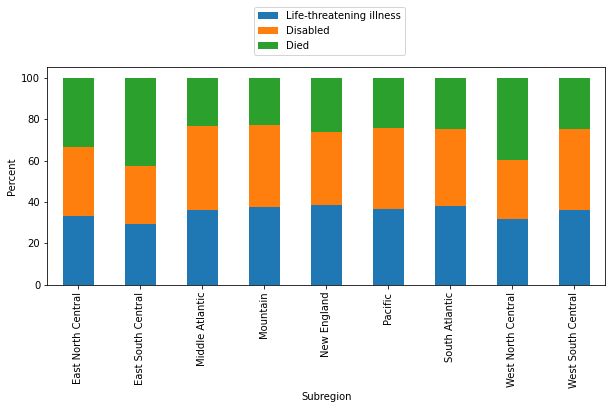

In [11]:
table_crit_pcnt.plot.bar(figsize=(10,4), stacked=True, xlabel='Subregion', ylabel='Percent').legend(bbox_to_anchor=(0.65,1.3))

## Create table showing state-level statistics for VAERS reported death count
* death count per million residents
* death count per million residents receiving at least one COVID-19 dose
Export to csv for import into external GIS application.  

Figure was prepared in QGIS and is included in this folder in the repository.

In [12]:
s_state_dth = df_reg.groupby(['STATE'])['DIED'].count()

df_state_pop = df_st[['STATE','Pop','POP_VAC']].copy()
df_state_pop.set_index(['STATE'], inplace=True)

table_state_dth = pd.merge(s_state_dth, df_state_pop, on='STATE', how='right')
table_state_dth['Rate_per_Mill'] = round((table_state_dth['DIED'] / table_state_dth['Pop']) * 1000000,1)
table_state_dth['Rate_per_Mill_Vac'] = round((table_state_dth['DIED'] / table_state_dth['POP_VAC']) * 1000000,1)

table_state_dth.to_csv('State_DIED_rate.csv')
table_state_dth.head()

,DIED,Pop,POP_VAC,Rate_per_Mill,Rate_per_Mill_Vac
STATE,,,,,
IL,208,12569321,7496343.0,16.5,27.7
IN,120,6805663,3044173.0,17.6,39.4
MI,179,9992427,5152095.0,17.9,34.7
OH,143,11714618,5662846.0,12.2,25.3
WI,100,5852490,3149810.0,17.1,31.7
